In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Augmentation을 적용한 데이터셋 만들기

In [3]:
(ds_raw, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

total_count = ds_info.splits['train'].num_examples
train_count = int(total_count * 0.8)
ds_train = ds_raw.take(train_count)
ds_val = ds_raw.skip(train_count)

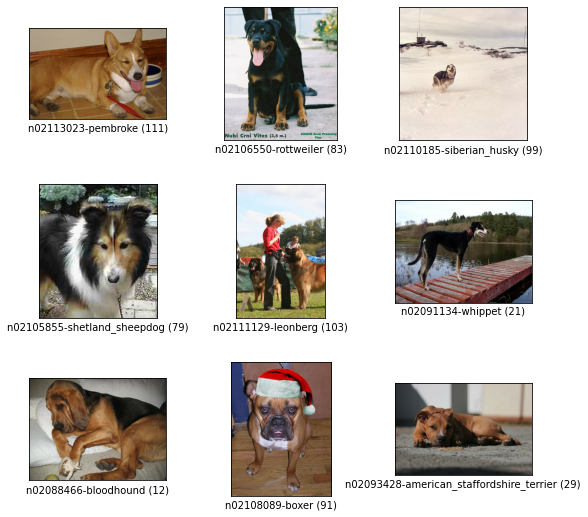

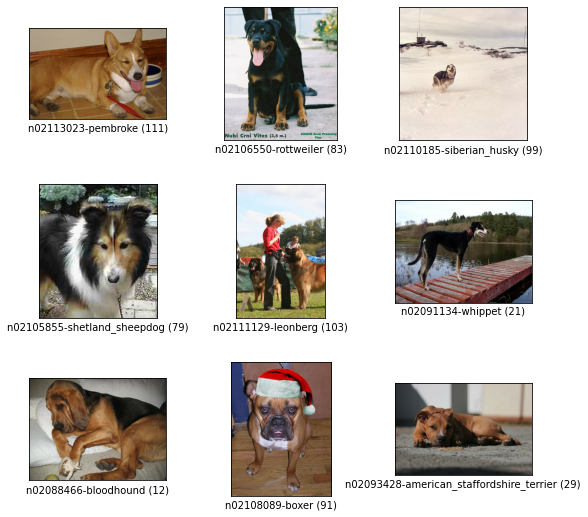

In [4]:
# 데이터셋 확인
tfds.show_examples(ds_train, ds_info)

In [5]:
num_classes = ds_info.features["label"].num_classes
print(num_classes)

120


In [6]:
IMAGE_SIZE = 100

### 기본 Augmentation

In [7]:
# 이미지 전처리
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### CutMix Augmentation

In [8]:
# 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [9]:
# mix two images
# 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [10]:
# mix two labels
# 면적에 비례해서 라벨을 섞어줌
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [11]:
# 배치 단위의 cutmix() 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=IMAGE_SIZE, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup Augmentation

In [12]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [13]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=IMAGE_SIZE, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Augmentation 적용

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_val = apply_normalize_on_dataset(ds_val, is_test=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [16]:
def show_images_only(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for images, _ in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(2, n // 2, i + 1)
            image = tf.clip_by_value(images[i], 0.0, 1.0)
            plt.imshow(image)
            ax.axis("off")
    plt.tight_layout()
    plt.show()

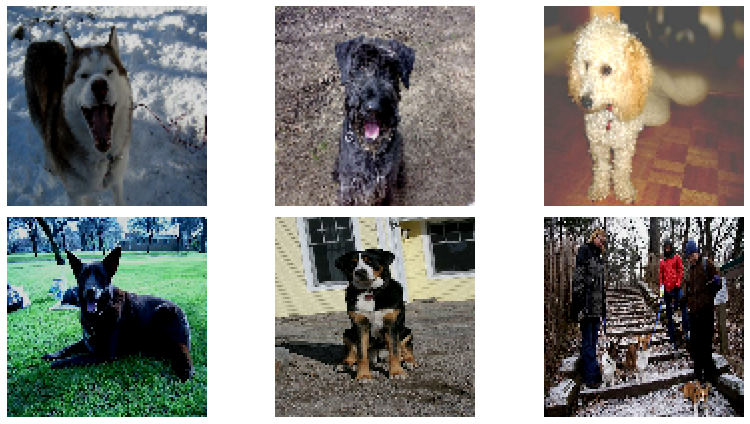

In [17]:
show_images_only(ds_train_aug)

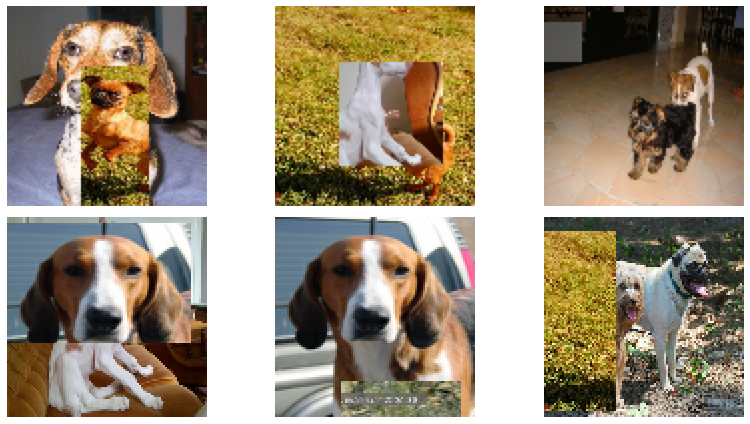

In [18]:
show_images_only(ds_train_cutmix)

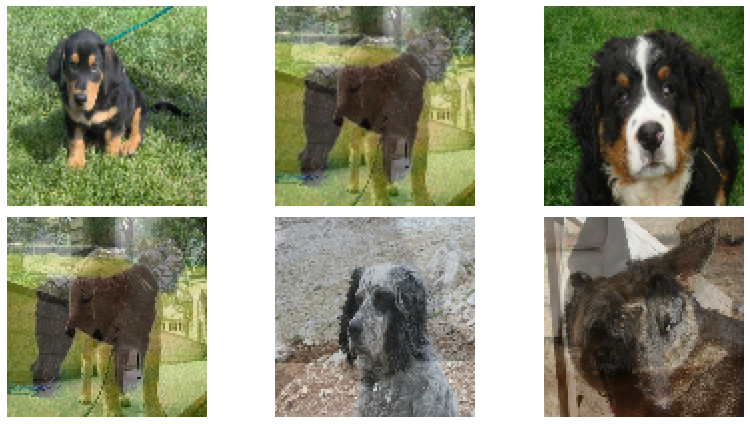

In [19]:
show_images_only(ds_train_mixup)

### 모델 만들기

In [20]:
# 기본 ResNet-50 모델
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
# 증강 데이터 ResNet-50 모델
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
# cutmix 증강 데이터 ResNet-50 모델
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
# mixup 증강 데이터 ResNet-50 모델
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 모델 훈련하기

In [24]:
EPOCH = 50  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
BATCH_SIZE = 16

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

steps_per_epoch = train_count // BATCH_SIZE
validation_steps = (total_count-train_count) // BATCH_SIZE

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
600/600 [==============================] - 54s 74ms/step - loss: 3.5945 - accuracy: 0.1834 - val_loss: 5.0185 - val_accuracy: 0.0125
Epoch 2/50
600/600 [==============================] - 44s 74ms/step - loss: 1.7209 - accuracy: 0.5622 - val_loss: 2.7332 - val_accuracy: 0.3433
Epoch 3/50
600/600 [==============================] - 46s 76ms/step - loss: 0.6149 - accuracy: 0.8682 - val_loss: 2.5710 - val_accuracy: 0.3812
Epoch 4/50
600/600 [==============================] - 46s 76ms/step - loss: 0.1322 - accuracy: 0.9861 - val_loss: 2.4363 - val_accuracy: 0.4304
Epoch 5/50
600/600 [==============================] - 46s 76ms/step - loss: 0.0455 - accuracy: 0.9977 - val_loss: 2.4691 - val_accuracy: 0.4296
Epoch 6/50
600/600 [==============================] - 46s 76ms/step - loss: 0.0242 - accuracy: 0.9991 - val_loss: 2.4840 - val_accuracy: 0.4329
Epoch 7/50
600/600 [==============================] - 46s 77ms/step - loss: 0.0159 - accuracy: 0.9996 - val_loss: 2.5028 - val_accuracy:

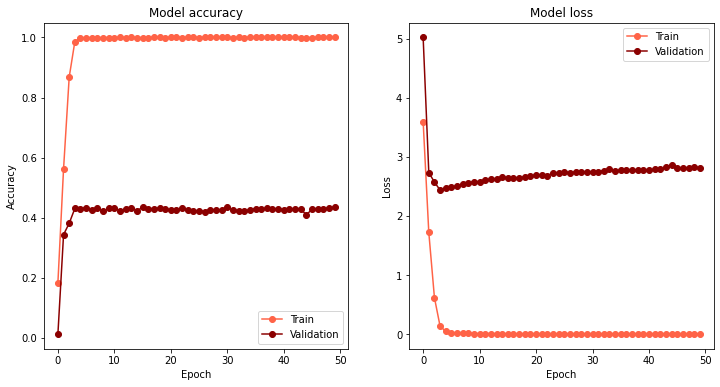

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(history_resnet50_no_aug.history['accuracy'], color='tomato', marker='o', linestyle='solid')
plt.plot(history_resnet50_no_aug.history['val_accuracy'], color='darkred', marker='o', linestyle='solid')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(history_resnet50_no_aug.history['loss'], color='tomato', marker='o', linestyle='solid')
plt.plot(history_resnet50_no_aug.history['val_loss'], color='darkred', marker='o', linestyle='solid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [26]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
600/600 [==============================] - 52s 78ms/step - loss: 3.6975 - accuracy: 0.1623 - val_loss: 5.0207 - val_accuracy: 0.0121
Epoch 2/50
600/600 [==============================] - 46s 76ms/step - loss: 2.1721 - accuracy: 0.4372 - val_loss: 3.1789 - val_accuracy: 0.2304
Epoch 3/50
600/600 [==============================] - 46s 76ms/step - loss: 1.3610 - accuracy: 0.6404 - val_loss: 2.6646 - val_accuracy: 0.3717
Epoch 4/50
600/600 [==============================] - 46s 77ms/step - loss: 0.7680 - accuracy: 0.8071 - val_loss: 2.5356 - val_accuracy: 0.4021
Epoch 5/50
600/600 [==============================] - 46s 76ms/step - loss: 0.4018 - accuracy: 0.9067 - val_loss: 2.6207 - val_accuracy: 0.4117
Epoch 6/50
600/600 [==============================] - 46s 76ms/step - loss: 0.2100 - accuracy: 0.9610 - val_loss: 2.5876 - val_accuracy: 0.4117
Epoch 7/50
600/600 [==============================] - 46s 77ms/step - loss: 0.1149 - accuracy: 0.9806 - val_loss: 2.6345 - val_accuracy:

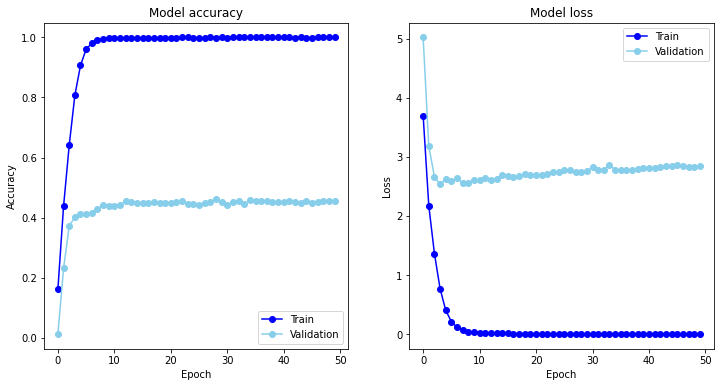

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(history_resnet50_aug.history['accuracy'], color='blue', marker='o', linestyle='solid')
plt.plot(history_resnet50_aug.history['val_accuracy'], color='skyblue', marker='o', linestyle='solid')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(history_resnet50_aug.history['loss'], color='blue', marker='o', linestyle='solid')
plt.plot(history_resnet50_aug.history['val_loss'], color='skyblue', marker='o', linestyle='solid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [28]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
600/600 [==============================] - 53s 78ms/step - loss: 4.6955 - accuracy: 0.0390 - val_loss: 5.0586 - val_accuracy: 0.0104
Epoch 2/50
600/600 [==============================] - 45s 76ms/step - loss: 4.0929 - accuracy: 0.1352 - val_loss: 3.2756 - val_accuracy: 0.2108
Epoch 3/50
600/600 [==============================] - 45s 76ms/step - loss: 3.6842 - accuracy: 0.2340 - val_loss: 2.8699 - val_accuracy: 0.2988
Epoch 4/50
600/600 [==============================] - 46s 77ms/step - loss: 3.4664 - accuracy: 0.3002 - val_loss: 2.6961 - val_accuracy: 0.3254
Epoch 5/50
600/600 [==============================] - 46s 77ms/step - loss: 3.2277 - accuracy: 0.3705 - val_loss: 2.6906 - val_accuracy: 0.3279
Epoch 6/50
600/600 [==============================] - 46s 77ms/step - loss: 3.0271 - accuracy: 0.4381 - val_loss: 2.7444 - val_accuracy: 0.3346
Epoch 7/50
600/600 [==============================] - 46s 77ms/step - loss: 2.8197 - accuracy: 0.5005 - val_loss: 2.6411 - val_accuracy:

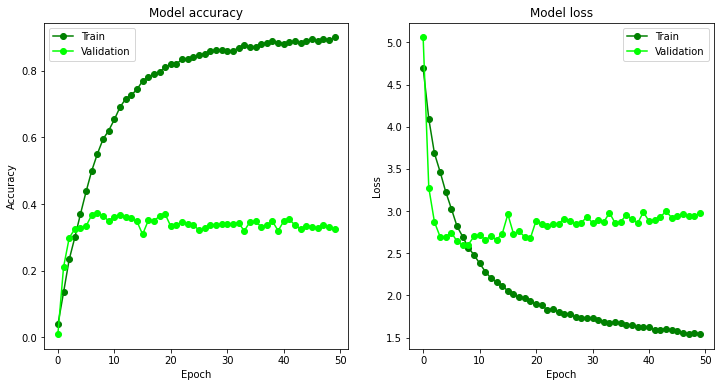

In [29]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(history_resnet50_cutmix.history['accuracy'], color='green', marker='o', linestyle='solid')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], color='lime', marker='o', linestyle='solid')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(history_resnet50_cutmix.history['loss'], color='green', marker='o', linestyle='solid')
plt.plot(history_resnet50_cutmix.history['val_loss'], color='lime', marker='o', linestyle='solid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [30]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup augmentation 적용한 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
600/600 [==============================] - 52s 78ms/step - loss: 4.5504 - accuracy: 0.0643 - val_loss: 4.9328 - val_accuracy: 0.0079
Epoch 2/50
600/600 [==============================] - 46s 76ms/step - loss: 3.8057 - accuracy: 0.2036 - val_loss: 3.1341 - val_accuracy: 0.2317
Epoch 3/50
600/600 [==============================] - 47s 78ms/step - loss: 3.3696 - accuracy: 0.3232 - val_loss: 2.9898 - val_accuracy: 0.2825
Epoch 4/50
600/600 [==============================] - 47s 78ms/step - loss: 3.0909 - accuracy: 0.4166 - val_loss: 2.8863 - val_accuracy: 0.3071
Epoch 5/50
600/600 [==============================] - 46s 77ms/step - loss: 2.8559 - accuracy: 0.5091 - val_loss: 2.8460 - val_accuracy: 0.3121
Epoch 6/50
600/600 [==============================] - 46s 77ms/step - loss: 2.6835 - accuracy: 0.5657 - val_loss: 2.8925 - val_accuracy: 0.3217
Epoch 7/50
600/600 [==============================] - 46s 77ms/step - loss: 2.5085 - accuracy: 0.6328 - val_loss: 2.7840 - val_accuracy:

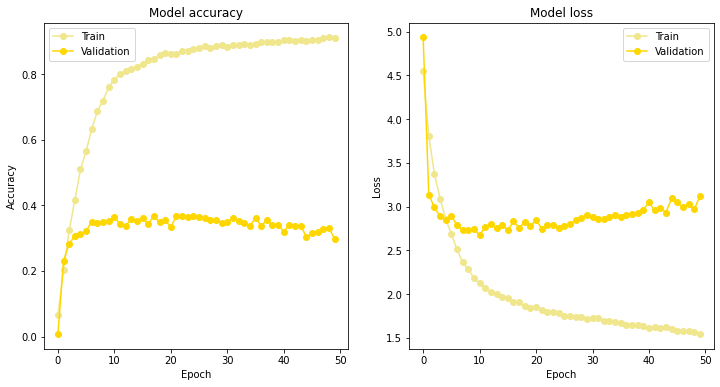

In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(history_resnet50_mixup.history['accuracy'], color='khaki', marker='o', linestyle='solid')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='gold', marker='o', linestyle='solid')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(history_resnet50_mixup.history['loss'], color='khaki', marker='o', linestyle='solid')
plt.plot(history_resnet50_mixup.history['val_loss'], color='gold', marker='o', linestyle='solid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

### 훈련 과정 시각화

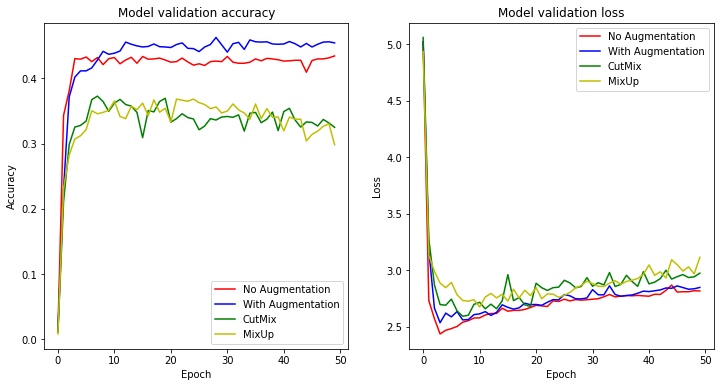

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'])

plt.subplot(1,2,2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'y')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'])
plt.show()

### Augmentation에 의한 모델 성능 비교

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(models: dict, ds_test, n_classes: int):
    """
    여러 모델의 다중 클래스 ROC 커브를 한 그래프에 그려 비교합니다.
    
    Args:
        models (dict): {"모델이름": 모델 객체} 형태의 dict
        ds_test: tf.data.Dataset 형태 (image_batch, label_batch)
        n_classes (int): 클래스 개수
    """
    plt.figure(figsize=(8, 8))
    
    for model_name, model in models.items():
        y_true_list = []
        y_pred_list = []
        
        # 예: ds_test는 (image_batch, label_batch) 튜플 형태
        for x_batch, y_batch in ds_test:
            preds = model.predict(x_batch, verbose=0)  # 예측 결과 (softmax 확률)
            y_pred_list.append(preds)
            y_true_list.append(y_batch)

        # 리스트 → NumPy 배열로 결합
        y_true = np.concatenate(y_true_list, axis=0)
        y_pred = np.concatenate(y_pred_list, axis=0)

        # 라벨이 one-hot 벡터라면 정수로 변환
        if len(y_true.shape) > 1 and y_true.shape[1] > 1:
            y_true_labels = np.argmax(y_true, axis=1)
        else:
            y_true_labels = y_true

        y_true_bin = label_binarize(y_true_labels, classes=np.arange(n_classes))

        # ROC 커브 및 AUC
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{model_name} (AUROC = {roc_auc:.4f})')

    # 랜덤 분류선
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUROC = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve (Micro-average)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

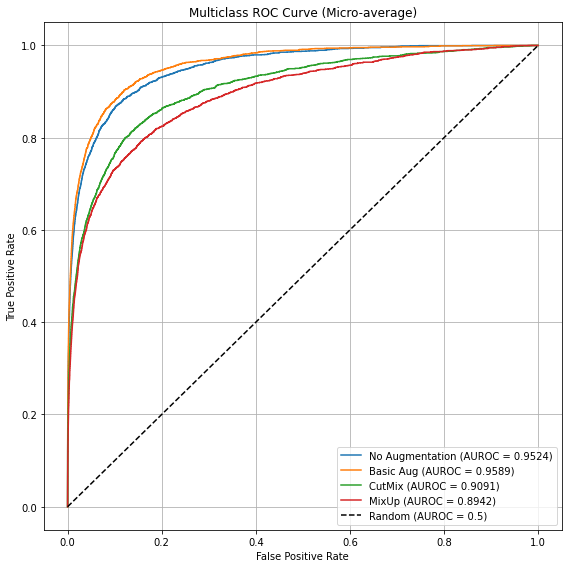

In [34]:
models = {
    "No Augmentation": resnet50,
    "Basic Aug": aug_resnet50,
    "CutMix": cutmix_resnet50,
    "MixUp": mixup_resnet50
}

plot_multiclass_roc(models=models, ds_test=ds_val, n_classes=120)

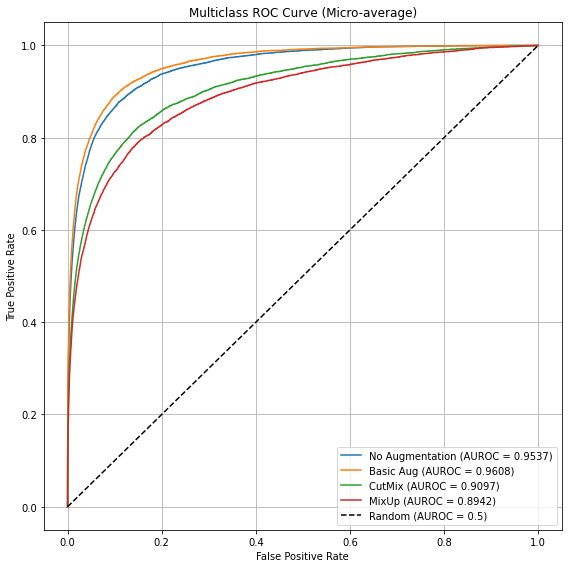

In [35]:
plot_multiclass_roc(models=models, ds_test=ds_test, n_classes=120)

In [36]:
def resnet_evaluate(models: dict, ds_test, n_classes: int):
    
    for model_name, model in models.items():
        loss, accuracy = model.evaluate(ds_test)
        print("Model Name: ", model_name)
        print("Test Loss:", loss)
        print("Test Accuracy:", accuracy)
        print("--------------------------------------")
            
resnet_evaluate(models=models, ds_test=ds_test, n_classes=120)

537/537 [==============================] - 11s 21ms/step - loss: 2.8177 - accuracy: 0.4202
Model Name:  No Augmentation
Test Loss: 2.8176558017730713
Test Accuracy: 0.42016318440437317
--------------------------------------
537/537 [==============================] - 11s 21ms/step - loss: 2.8017 - accuracy: 0.4552
Model Name:  Basic Aug
Test Loss: 2.801668405532837
Test Accuracy: 0.4552447497844696
--------------------------------------
537/537 [==============================] - 11s 21ms/step - loss: 2.9721 - accuracy: 0.3300
Model Name:  CutMix
Test Loss: 2.972130537033081
Test Accuracy: 0.3299533724784851
--------------------------------------
537/537 [==============================] - 11s 20ms/step - loss: 3.1271 - accuracy: 0.3085
Model Name:  MixUp
Test Loss: 3.1270835399627686
Test Accuracy: 0.30850815773010254
--------------------------------------


|제목|내용|설명|
|------|---|---|
|테스트1|테스트2|테스트3|
|테스트1|테스트2|테스트3|
|테스트1|테스트2|테스트3|